c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0884 - loss: 2.5103 - val_accuracy: 0.1140 - val_loss: 2.4783
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1364 - loss: 2.4574 - val_accuracy: 0.1295 - val_loss: 2.4646
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1358 - loss: 2.4409 - val_accuracy: 0.1319 - val_loss: 2.4580
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1377 - loss: 2.4277 - val_accuracy: 0.1148 - val_loss: 2.4559
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1444 - loss: 2.4158 - val_accuracy: 0.1254 - val_loss: 2.4442
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1579 - loss: 2.3986 - val_accuracy: 0.1279 - val_loss: 2.4435
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1564 - loss: 2.3846 - val_accuracy: 0.1295 - val_loss: 2.4312
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1744 - loss: 2.3700 - val_accuracy: 0.

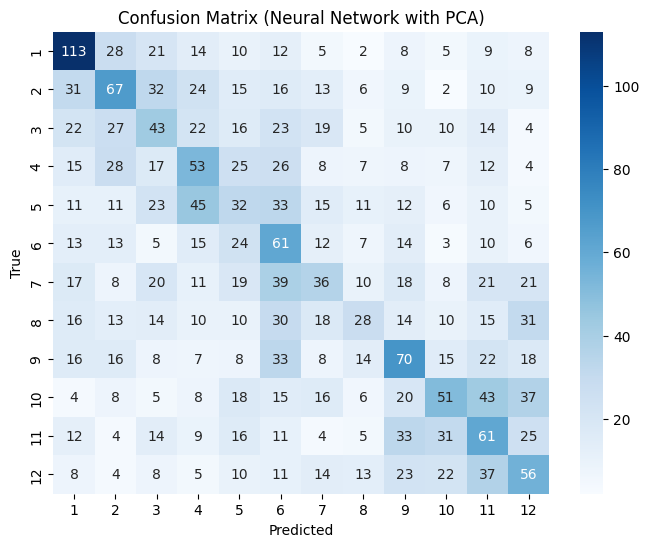

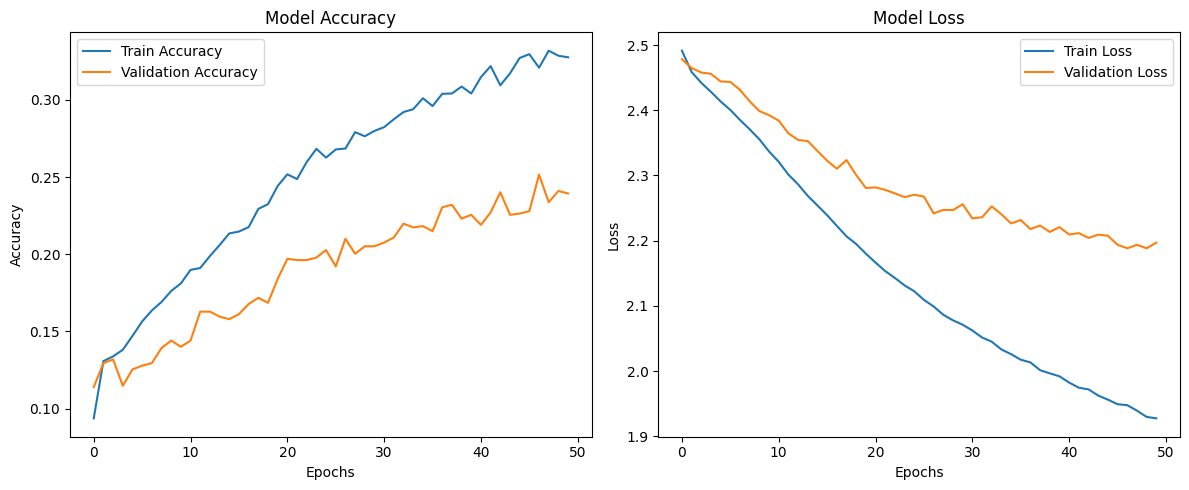


Model Performance Summary:
                               Metric      Score
0                        Accuracy (%)  25.513308
1  Cross-Validation Mean Accuracy (%)  14.895710
2   Cross-Validation Std Accuracy (%)   0.606671


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load the dataset
data = pd.read_csv('scaled_hand_angles.csv')  # Update the file path if needed

# Step 2: Define features (X) and target labels (y)
X = data.drop('target', axis=1)  # Drop the target column to get features
y = data['target']  # Extract the target column as the label

# Encode target labels (convert categorical labels to integers)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the target labels for NN
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# Step 4: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Step 5: Build the Neural Network Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_pca.shape[1],)),  # Use PCA-transformed features
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Perform Cross-validation (manual cross-validation with KFold)
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Collect accuracy across folds
cv_accuracies = []
for train_index, val_index in kf.split(X_train_pca):
    X_train_cv, X_val_cv = X_train_pca[train_index], X_train_pca[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    # Build and train the model for this fold
    fold_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train_pca.shape[1],)),  # Use PCA-transformed features
        tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 1
        tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
        tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')  # Output layer
    ])
    fold_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    fold_model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=0)

    # Evaluate on the validation set
    val_loss, val_accuracy = fold_model.evaluate(X_val_cv, y_val_cv, verbose=0)
    cv_accuracies.append(val_accuracy)

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_accuracy = np.mean(cv_accuracies)
std_cv_accuracy = np.std(cv_accuracies)

# Step 7: Train the Neural Network
history = model.fit(X_train_pca, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Step 8: Evaluate the Neural Network
y_pred_probs = model.predict(X_test_pca)
y_pred = y_pred_probs.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

accuracy_nn = accuracy_score(y_test_labels, y_pred) * 100  # Convert to percentage
print(f"Neural Network Accuracy: {accuracy_nn:.2f}%")  # Display accuracy

target_names = [str(label) for label in label_encoder.classes_]

# Generate the classification report with target names as strings
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 9: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Neural Network with PCA)')
plt.show()

# Step 10: Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Create a summarized performance table
summary_data = {
    'Metric': ['Accuracy (%)', 'Cross-Validation Mean Accuracy (%)', 'Cross-Validation Std Accuracy (%)'],
    'Score': [accuracy_nn, mean_cv_accuracy * 100, std_cv_accuracy * 100]
}

summary_df = pd.DataFrame(summary_data)

print("\nModel Performance Summary:")
print(summary_df)
